# Quora Question Pair Similarity Detection using NLP and Machine Learning
 Identifying questions on quora with same intent

## Problem Statement
Quora, a popular knowledge-sharing platform, faces a challenge with duplicate questions. This issue can lead to:

1. Users spending more time searching for answers
2. Writers answering similar questions multiple times

The goal is to improve this system by developing more advanced natural language processing techniques to classify question pairs as duplicates or not.

Benefits of solving this problem include:

- Enhanced user experience for question askers and answerers
- Easier access to high-quality answers
- More efficient knowledge sharing

This challenge invites participants to create innovative solutions that can accurately identify duplicate questions, ultimately improving Quora's ability to connect people with the information they seek.

 Data is taken from kaggle competition (2017) : https://kaggle.com/competitions/quora-question-pairs

## Data Details
 1. id - the id of a training set question pair
 2. qid1, qid2 - unique ids of each question (only available in train.csv)
 3. question1, question2 - the full text of each question
 4. is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.

## Importing Needed Libraries.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from fuzzywuzzy import fuzz
import distance
from nltk.metrics import jaccard_distance
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from tqdm import tqdm
import spacy
from spacy.cli import download
import torch
from torch import nn
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer, TFBertModel
from torch.optim.lr_scheduler import ReduceLROnPlateau
from nlpaug.augmenter.word import SynonymAug
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
from nltk.corpus import stopwords
from collections import Counter

/home/ubuntu/Final_Project/final/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/home/ubuntu/Final_Project/final/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-06 23:58:23.597125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733529503.830758    1923 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733529503.903571    1923 cuda_blas.cc:

## Load the Data and Perform Data Analysis

In [3]:
data = pd.read_csv('train.csv')

 First 5 rows of data

In [3]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [85]:
print(f"Number of Observations in data are {data.shape[0]}")

Number of Observations in data are 404290


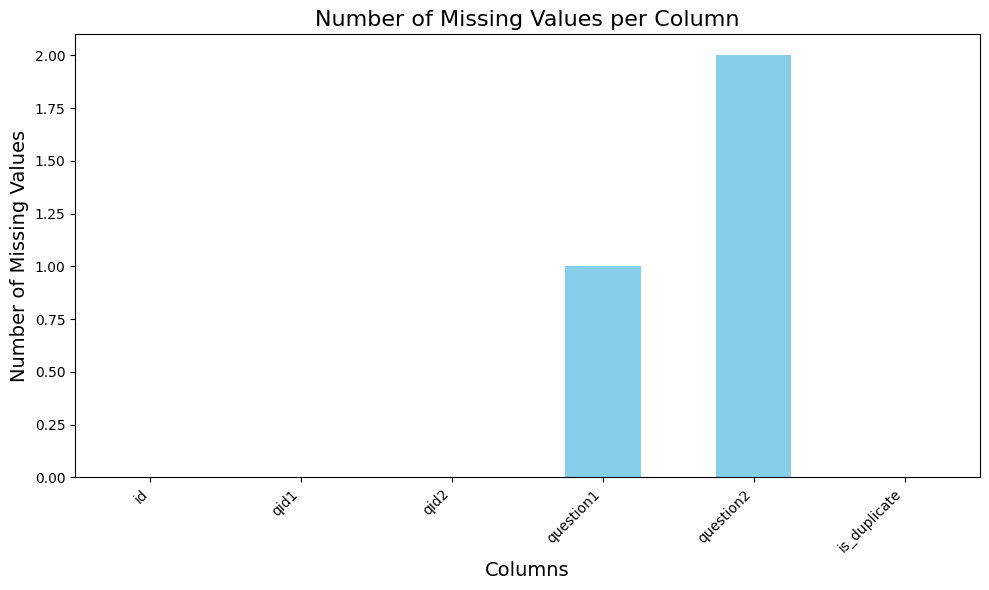

In [ ]:
data.replace('', np.nan, inplace=True)

# Count missing (NaN) values per column
missing_values_count = data.isnull().sum()

# Plot missing values
plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Values per Column', fontsize=16)
plt.xlabel('Columns', fontsize=14)
plt.ylabel('Number of Missing Values', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout() 
plt.show()

 Note: There are two null values in question 2 and one null value in question 1, dropping those rows.

In [87]:
rows_before_drop = len(data)
data = data.dropna()
rows_after_drop = len(data)
rows_dropped = rows_before_drop - rows_after_drop
print("Number of rows dropped:", rows_dropped)

Number of rows dropped: 3


## Distribution of data points among output classes (Similar and Non Similar Questions)
 Check for Balance of Data (Ouput Column: is_duplicate)

 Checking for Duplicates

In [88]:
# Check for rows where qid1 and qid2 are the same
same_qid_rows = data[data['qid1'] == data['qid2']]

# Check for rows where qid1 and qid2 are interchanged
interchanged_qid_rows = data[data.apply(lambda row: row['qid1'] == row['qid2'] or (row['qid1'] == row['qid2'] and row['qid1'] is not None and row['qid2'] is not None), axis=1)]

# Display the results
print("Rows where qid1 and qid2 are the same:")
print(same_qid_rows)

print("\nRows where qid1 and qid2 are interchanged:")
print(interchanged_qid_rows)

# Count the total number of duplicate pairs
total_duplicates = len(same_qid_rows) + len(interchanged_qid_rows)
print("Total number of duplicate pairs:", total_duplicates)

Rows where qid1 and qid2 are the same:
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []

Rows where qid1 and qid2 are interchanged:
Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []
Total number of duplicate pairs: 0


 Number of Occurances of each question.

Total number of Unique Questions: 537929

Number of unique questions that appear more than one time: 111778 (20.78%)

Max number of times a single question is repeated: 157



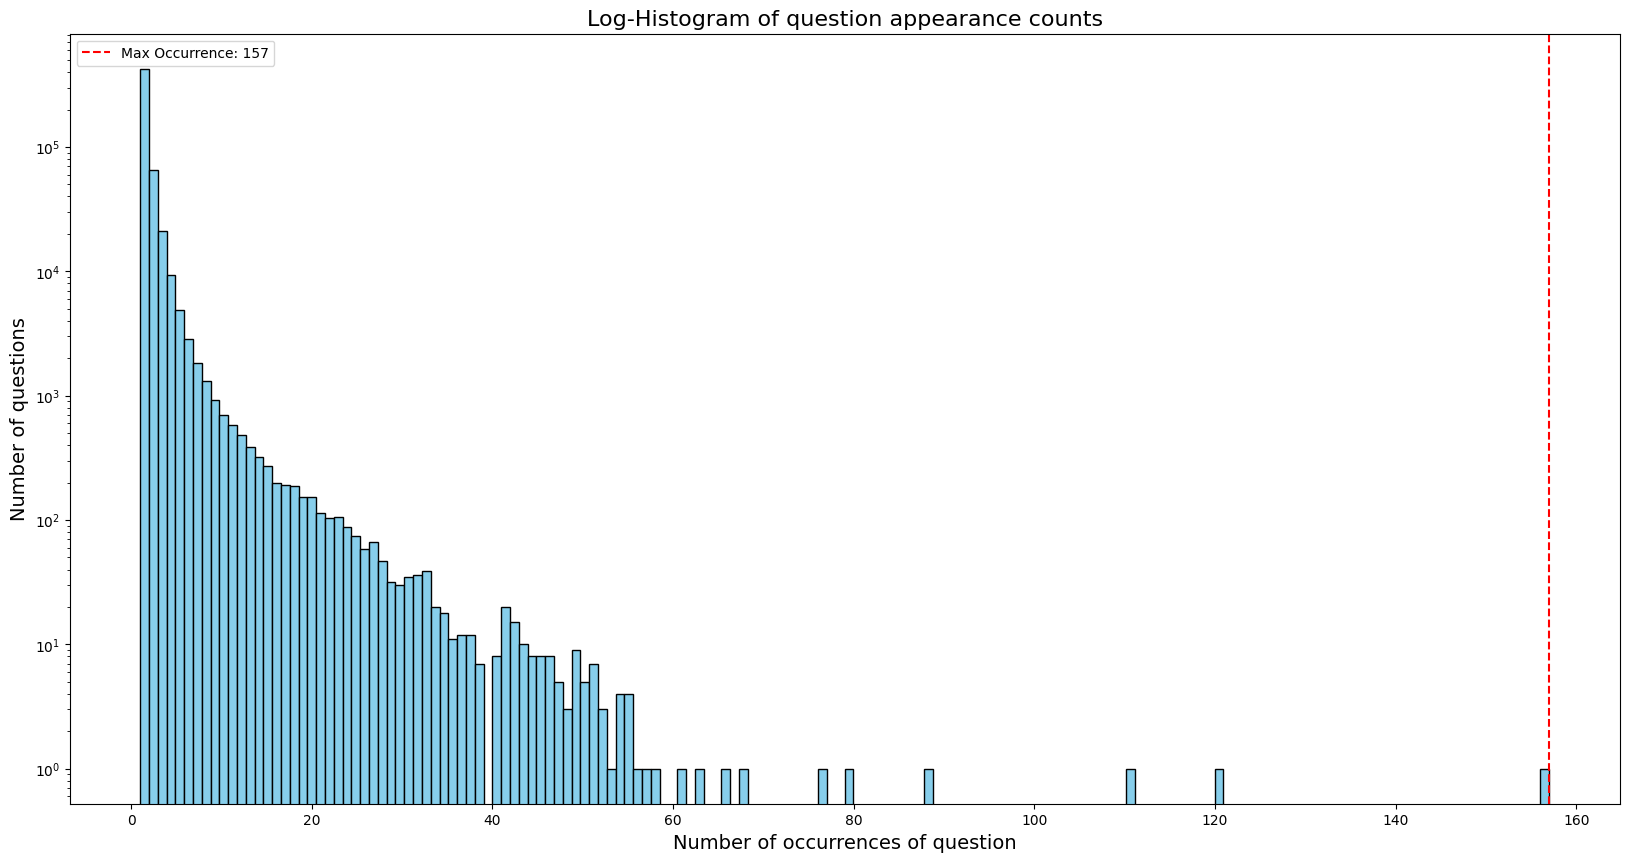

In [89]:
qids = pd.Series(data['qid1'].tolist() + data['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)

print('Total number of Unique Questions: {}\n'.format(unique_qs))
print('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime, round(qs_morethan_onetime/unique_qs*100,2)))
print('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts())))
plt.figure(figsize=(20, 10))

counts, bins, _ = plt.hist(qids.value_counts(), bins=160, color='skyblue', edgecolor='black')

plt.yscale('log', nonpositive='clip')

plt.title('Log-Histogram of question appearance counts', fontsize=16)
plt.xlabel('Number of occurrences of question', fontsize=14)
plt.ylabel('Number of questions', fontsize=14)

max_occurrence = max(qids.value_counts())
plt.axvline(x=max_occurrence, color='red', linestyle='--', label=f'Max Occurrence: {max_occurrence}')

plt.legend()

plt.show()

 The plot is close to a power-law distribution not exactly power-law but close to it.

### Top 10 Most asked questions on Quora:

In [90]:
all_questions = pd.concat([data['question1'], data['question2']], ignore_index=True)
top_10_common_questions = all_questions.value_counts().head(10)

print("Top 10 Most Common Questions:")
print(top_10_common_questions)

Top 10 Most Common Questions:
What are the best ways to lose weight?                                                                161
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
How can you increase your height?                                                                      63
How do l see who

### Distribution of Question Lengths:

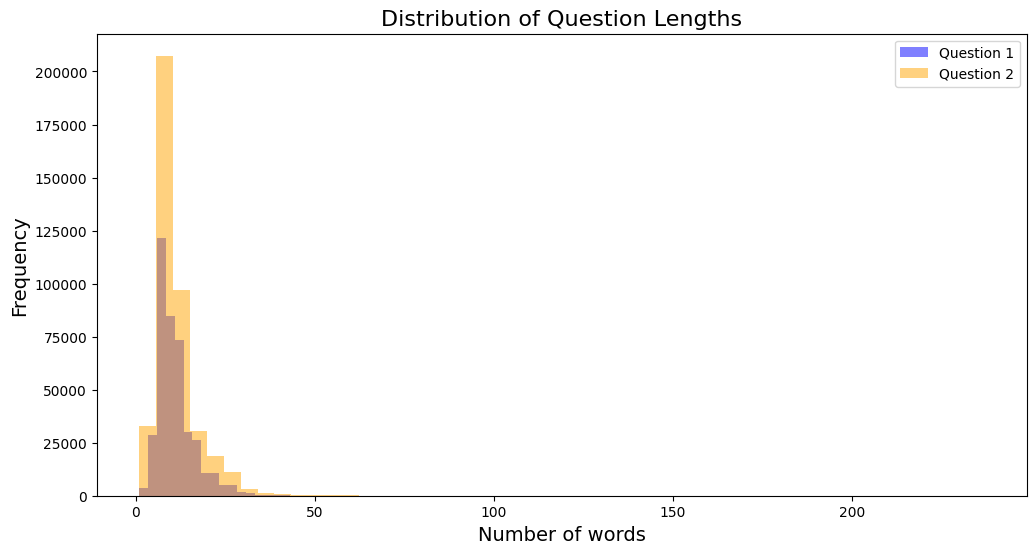

In [91]:
# Function to count the number of words in a sentence
def count_words(sentence):
    # Handle the case where the sentence is NaN (missing value)
    if pd.isnull(sentence):
        return 0
    # Count the number of words by splitting the sentence
    return len(str(sentence).split())

# Plot histograms for question lengths
plt.figure(figsize=(12, 6))
plt.hist(data['question1'].apply(lambda x: count_words(x)), bins=50, alpha=0.5, label='Question 1', color='blue')
plt.hist(data['question2'].apply(lambda x: count_words(x)), bins=50, alpha=0.5, label='Question 2', color='orange')

# Title and labels
plt.title('Distribution of Question Lengths', fontsize=16)
plt.xlabel('Number of words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Display legend
plt.legend()

plt.show()

## Feature Extraction
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2

### Feature Extraction after pre-processing.
 Featurization (NLP and Fuzzy Features)
 Definition:
 - __Token__: You get a token by splitting sentence a space
 - __Stop_Word__ : stop words as per NLTK.
 - __Word__ : A token that is not a stop_word
 <br>
 <br>
 __Features__:
 - __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
 <br>
 <br>
 - __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
 <br>
 <br>
 - __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
 <br>
 <br>
 - __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
 <br>
 <br>
 - __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
 <br>
 <br>
 - __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
 <br>
 <br>
 - __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
 <br>
 <br>
 - __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
 <br>
 <br>
 - __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
 <br>
 <br>
 - __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
 <br>
 <br>
 - __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
 http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
 <br>
 <br>
 - __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens)) <br>
## Some additional features - Adding some more features which I feel will add good information. <br>
 ratio_q_lengths:  This feature calculates the ratio of the lengths of the two questions. <br>
 common_prefix: This feature computes the length of the common prefix (the initial common sequence of characters) between the two questions. <br>
 common_suffix: This feature calculates the length of the common suffix (the final common sequence of characters) between the two questions. <br>
 diff_words: This feature calculates the absolute difference in the number of words between the two questions. <br>
 diff_chars: This feature computes the absolute difference in the number of characters between the two questions. <br>
 jaccard_similarity: This feature calculates the Jaccard similarity coefficient between the sets of words in the two questions. <br>
 longest_common_subsequence: This feature computes the length of the longest common subsequence (LCS) between the two questions. <br>

## Processing and Extracting Features

## Pre-processing of Text

 - Preprocessing:
 1. Removing Punctuations
 2. Performing Lemmatization
 3. Removing Stopwords
 4. Expanding contractions etc.

## Extracting Features

In [ ]:
class_proportions = data['is_duplicate'].value_counts(normalize=True)
sample_size = int(0.3 * len(data))
stratified_sample = data.groupby('is_duplicate', group_keys=False).apply(
    lambda x: x.sample(n=int(class_proportions[x.name] * sample_size), random_state=42)
)
stratified_sample = stratified_sample.reset_index(drop=True)

/tmp/ipykernel_2574/2388236435.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = data.groupby('is_duplicate', group_keys=False).apply(


In [ ]:
STOP_WORDS = stopwords.words("english")

def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("'", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    lemmatizer = WordNetLemmatizer()
    pattern = re.compile(r'\W')
    
    if isinstance(x, str):
        x = re.sub(pattern, ' ', x)
        words = x.split()
        lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
        x = ' '.join(lemmatized_words)
        
               
    return x

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [6]:
print("Preprocessing questions...")
stratified_sample['question1'] = stratified_sample['question1'].apply(preprocess)
stratified_sample['question2'] = stratified_sample['question2'].apply(preprocess)
print("Pre-Processing Completed")

Preprocessing questions...
Pre-Processing Completed


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


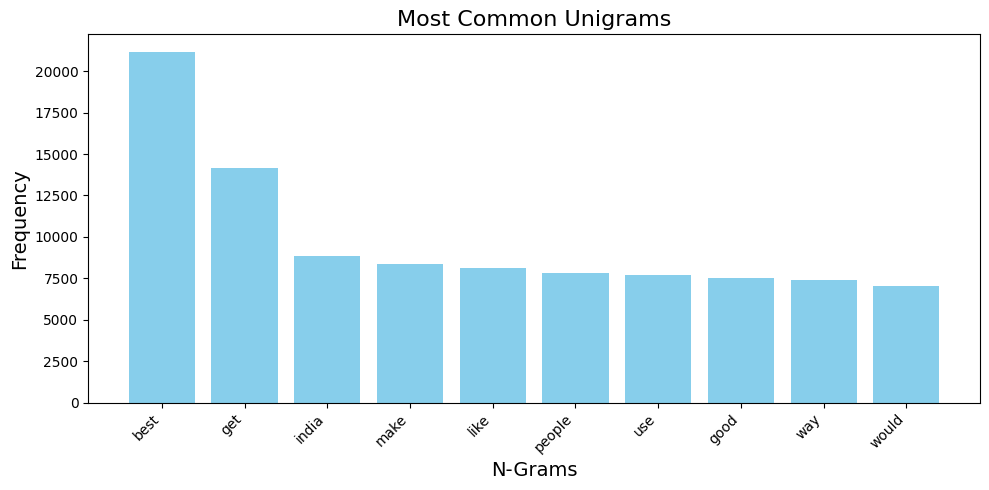

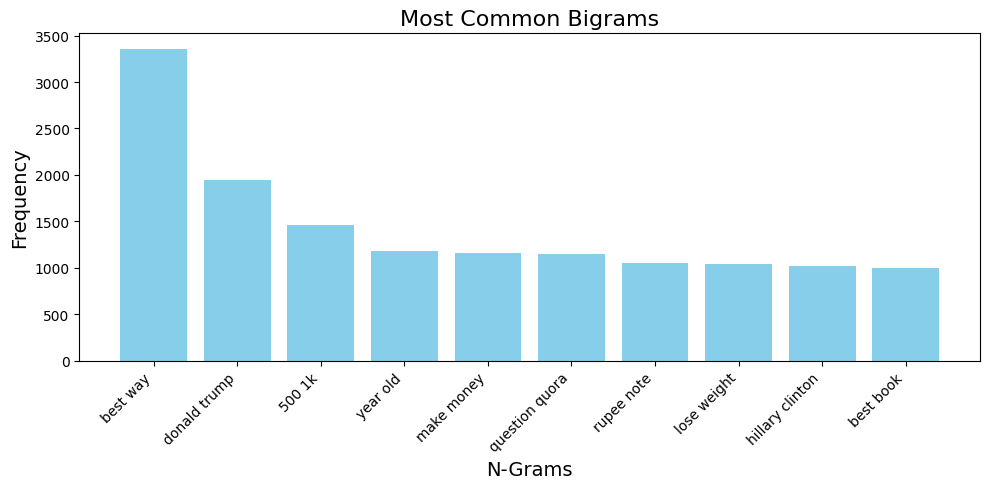

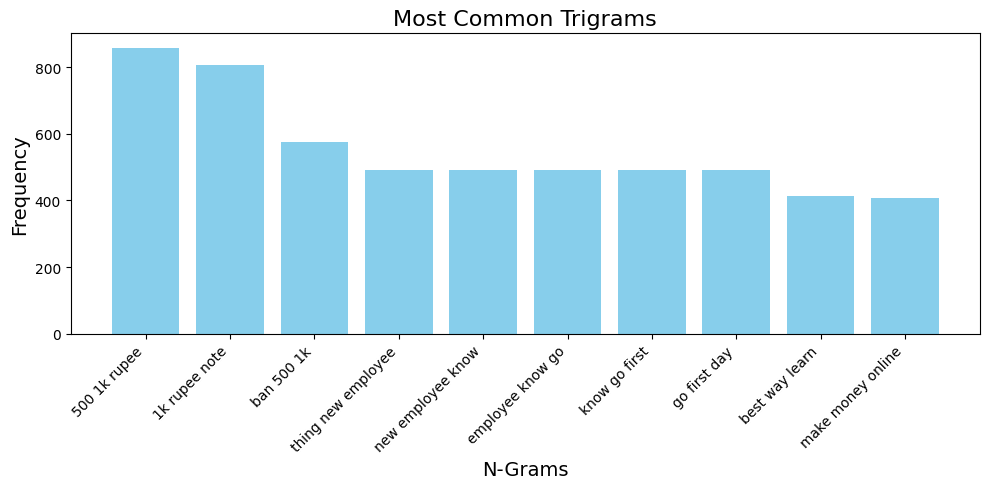

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
all_questions = pd.concat([stratified_sample['question1'], stratified_sample['question2']], axis=0).dropna()
def get_ngrams_without_stopwords(text_series, n):
    stop_words = set(stopwords.words('english'))
    ngram_counter = Counter()
    
    for text in text_series:
        tokens = [word for word in word_tokenize(str(text).lower()) if word not in stop_words]
        ngram_counter.update(ngrams(tokens, n))
    
    return ngram_counter
unigrams = get_ngrams_without_stopwords(all_questions, 1)
bigrams = get_ngrams_without_stopwords(all_questions, 2)
trigrams = get_ngrams_without_stopwords(all_questions, 3)

most_common_unigrams = unigrams.most_common(10)
most_common_bigrams = bigrams.most_common(10)
most_common_trigrams = trigrams.most_common(10)

# Function to plot n-grams
def plot_ngrams(ngrams, title):
    ngram_labels = [' '.join(item[0]) for item in ngrams] 
    ngram_frequencies = [item[1] for item in ngrams]

    plt.figure(figsize=(10, 5))
    plt.bar(ngram_labels, ngram_frequencies, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel('N-Grams', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
plot_ngrams(most_common_unigrams, "Most Common Unigrams")
plot_ngrams(most_common_bigrams, "Most Common Bigrams")
plot_ngrams(most_common_trigrams, "Most Common Trigrams")

In [ ]:
SAFE_DIV = 0.0001
STOP_WORDS = stopwords.words("english")

def get_token_features(q1, q2):
    token_features = [0.0]*10
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    common_word_count = len(q1_words.intersection(q2_words))
    common_stop_count = len(q1_stops.intersection(q2_stops))
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

def extract_features(data):
    print("Extracting features...")
    
    data['freq_qid1'] = data.groupby('qid1')['qid1'].transform('count')
    data['freq_qid2'] = data.groupby('qid2')['qid2'].transform('count')
    data['q1len'] = data['question1'].str.len()
    data['q2len'] = data['question2'].str.len()
    data['q1_n_words'] = data['question1'].apply(lambda x: len(str(x).split()))
    data['q2_n_words'] = data['question2'].apply(lambda x: len(str(x).split()))
    
    data['word_Common'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()) & set(str(x['question2']).lower().split())), axis=1)
    data['word_Total'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()) | set(str(x['question2']).lower().split())), axis=1)
    data['word_share'] = data['word_Common'] / data['word_Total']
    
    data['freq_q1+q2'] = data['freq_qid1'] + data['freq_qid2']
    data['freq_q1-q2'] = abs(data['freq_qid1'] - data['freq_qid2'])

    print("Calculating token features...")
    token_features = data.apply(lambda x: get_token_features(str(x['question1']), str(x['question2'])), axis=1)
    data['cwc_min'], data['cwc_max'], data['csc_min'], data['csc_max'], data['ctc_min'], data['ctc_max'], \
    data['last_word_eq'], data['first_word_eq'], data['abs_len_diff'], data['mean_len'] = zip(*token_features)

    print("Calculating fuzzy features...")
    data['token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_ratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1)
    data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1)
    data['longest_substr_ratio'] = data.apply(lambda x: get_longest_substr_ratio(str(x['question1']), str(x['question2'])), axis=1)

    print("Calculating additional features...")
    data['ratio_q_lengths'] = data.apply(lambda x: ratio_of_question_lengths(x['question1'], x['question2']), axis=1)
    data['common_prefix'] = data.apply(lambda x: common_prefix(str(x['question1']), str(x['question2'])), axis=1)
    data['common_suffix'] = data.apply(lambda x: common_suffix(str(x['question1']), str(x['question2'])), axis=1)
    data['diff_words'] = data.apply(lambda x: abs(x['q1_n_words'] - x['q2_n_words']), axis=1)
    data['diff_chars'] = data.apply(lambda x: abs(len(str(x['question1'])) - len(str(x['question2']))), axis=1)
    data['jaccard_similarity'] = data.apply(lambda x: jaccard_similarity(str(x['question1']), str(x['question2'])), axis=1)
    data['longest_common_subsequence'] = data.apply(lambda x: longest_common_subsequence(str(x['question1']), str(x['question2'])), axis=1)

    print("Feature extraction complete.")
    return data

def ratio_of_question_lengths(q1, q2):
    len_q1 = len(str(q1))
    len_q2 = len(str(q2))
    return len_q1 / len_q2 if len_q2 != 0 else 0.0

def common_prefix(q1, q2):
    i = 0
    while i < min(len(q1), len(q2)) and q1[i] == q2[i]:
        i += 1
    return i

def common_suffix(q1, q2):
    i, j = len(q1) - 1, len(q2) - 1
    while i >= 0 and j >= 0 and q1[i] == q2[j]:
        i -= 1
        j -= 1
    return len(q1) - i - 1

def jaccard_similarity(q1, q2):
    q1_tokens = set(q1.split())
    q2_tokens = set(q2.split())
    if not q1_tokens or not q2_tokens:
        return 0.0
    return 1.0 - jaccard_distance(q1_tokens, q2_tokens)

def longest_common_subsequence(q1, q2):
    seq1, seq2 = list(q1), list(q2)
    m, n = len(seq1), len(seq2)
    dp = [[0] * (n + 1) for _ in range(m + 1)]
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if seq1[i - 1] == seq2[j - 1]:
                dp[i][j] = dp[i - 1][j - 1] + 1
            else:
                dp[i][j] = max(dp[i - 1][j], dp[i][j - 1])
    return dp[m][n]

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    return len(strs[0]) / (min(len(a), len(b)) + 1) if strs else 0


data = extract_features(stratified_sample)

Extracting features...
Calculating token features...
Calculating fuzzy features...
Calculating additional features...
Feature extraction complete.


In [95]:
data.head(5)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,ratio_q_lengths,common_prefix,common_suffix,diff_words,diff_chars,jaccard_similarity,longest_common_subsequence
0,362767,492698,492699,what be some example of artificial satellite,what be artificial satellite,0,1,1,44,28,...,78,79,0.724138,1.571429,8,21,3,16,0.571429,28
1,398904,532147,532148,what do the term government mean,what do the term government 2 0 mean,0,1,1,32,36,...,94,88,0.848485,0.888889,28,5,2,4,0.750000,32
2,327293,453706,453707,be the usda constitutional,what be a usda loan,0,1,1,26,19,...,49,58,0.300000,1.368421,0,0,1,7,0.285714,11
3,368177,498520,498521,reservoir dog 1992 movie if they have live wou...,be the movie reservoir dog racist,0,1,1,92,33,...,29,48,0.411765,2.787879,0,0,11,59,0.166667,21
4,122529,198297,198298,what happens to an ant colony when a queen ant dy,why do ant carry away their dead,0,1,1,49,32,...,42,50,0.181818,1.531250,2,0,4,17,0.062500,19


### Check for questions with 2 words or less than 2 words

In [ ]:
filtered_data = data[(data['q1_n_words'] <= 2) | (data['q2_n_words'] <= 2)]
num_sentences = len(filtered_data)
print(f"Number of Sentences: {num_sentences}\n")

for index, row in filtered_data.head(10).iterrows():
    print(f"Q1: {row['question1']}")
    print(f"Q2: {row['question2']}")
    print(f"Is Duplicate: {row['is_duplicate']}")
    print("-" * 50)

Number of Sentences: 52

Q1: aaa
Q2: my dad always yell at me and cause me anxiety how do i fix this
Is Duplicate: 0
--------------------------------------------------
Q1: which kind of medical technology cause moral controversy bioprinting
Q2: stress definition
Is Duplicate: 0
--------------------------------------------------
Q1: 
Q2: what be cisco router technical support phone number
Is Duplicate: 0
--------------------------------------------------
Q1: marriage
Q2: marriage be an institution what do this mean
Is Duplicate: 0
--------------------------------------------------
Q1: 
Q2: what do i do with this guy
Is Duplicate: 0
--------------------------------------------------
Q1: me and my girlfriend wish to go out and do owntuff and we have just public place to go to where can we do it without anyone know
Q2: delete
Is Duplicate: 0
--------------------------------------------------
Q1: joseph armethia
Q2: be fleury lose the start job to matt murray
Is Duplicate: 0
---------------

In [ ]:
data['question1'] = data['question1'].replace('', np.nan)
data['question2'] = data['question2'].replace('', np.nan)
data = data.dropna(subset=['question1', 'question2'])

In [98]:
print ("Minimum length of the questions in question1 : " , min(data['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(data['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", data[data['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", data[data['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 12
Number of Questions with minimum length [question2] : 6


## Featurizing text data with Tf-Idf weighted word-vectors

In [100]:
df = pd.read_csv('train.csv')
sample_size = int(0.3 * len(data))
df = df.groupby('is_duplicate', group_keys=False).apply(
    lambda x: x.sample(n=int(class_proportions[x.name] * sample_size), random_state=42)
)
df = stratified_sample.reset_index(drop=True)

In [ ]:
warnings.filterwarnings("ignore")

df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))
questions = list(df['question1']) + list(df['question2'])

# TF-IDF vectorization
tfidf = TfidfVectorizer(lowercase=False)
tfidf.fit_transform(questions)
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

def load_spacy_model(model_name='en_core_web_lg'):
    try:
        nlp = spacy.load(model_name)
        print(f"spaCy model '{model_name}' loaded successfully.")
    except OSError:
        print(f"Model '{model_name}' not found. Downloading...")
        download(model_name)
        nlp = spacy.load(model_name)
        print(f"spaCy model '{model_name}' downloaded and loaded successfully.")

    return nlp

# Loading the spaCy model
nlp = load_spacy_model()
vecs1 = []
vecs2 = []

for qu1, qu2 in tqdm(zip(list(df['question1']), list(df['question2']))):
    doc1 = nlp(qu1)
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])

    for word1 in doc1:
        vec1 = word1.vector
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        mean_vec1 += vec1 * idf

    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)

    doc2 = nlp(qu2)
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])

    for word2 in doc2:
        vec2 = word2.vector
        try:
            idf = word2tfidf[str(word2)]
        except:
            idf = 0
        mean_vec2 += vec2 * idf

    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)

df['q1_feats_m'] = list(vecs1)
df['q2_feats_m'] = list(vecs2)

spaCy model 'en_core_web_lg' loaded successfully.


121285it [15:27, 130.72it/s]


In [102]:
df.to_csv('tqidf.csv', index=False)

In [ ]:
df1 = data.drop(['qid1', 'qid2', 'question1', 'question2'], axis=1)
df3 = df.drop(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], axis=1)
df3_q1 = pd.DataFrame(df3.q1_feats_m.values.tolist(), index=df3.index)
df3_q2 = pd.DataFrame(df3.q2_feats_m.values.tolist(), index=df3.index)
print("Number of features in nlp dataframe:", df1.shape[1])
print("Head(5) of nlp dataframe:")
print(df1.head(5))

print("\nNumber of features in question1 w2v dataframe:", df3_q1.shape[1])
print("Head(5) of question1 w2v dataframe:")
print(df3_q1.head(5))

print("\nNumber of features in question2 w2v dataframe:", df3_q2.shape[1])
print("Head(5) of question2 w2v dataframe:")
print(df3_q2.head(5))

print("\nNumber of features in the final dataframe:", df1.shape[1] + df3_q1.shape[1] + df3_q2.shape[1])

Number of features in nlp dataframe: 35
Head(5) of nlp dataframe:
       id  is_duplicate  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  \
0  362767             0          1          1     44     28           7   
1  398904             0          1          1     32     36           6   
2  327293             0          1          1     26     19           4   
3  368177             0          1          1     92     33          17   
4  122529             0          1          1     49     32          11   

   q2_n_words  word_Common  word_Total  ...  fuzz_ratio  fuzz_partial_ratio  \
0           4            4           7  ...          78                  79   
1           8            6           8  ...          94                  88   
2           5            2           7  ...          49                  58   
3           6            3          18  ...          29                  48   
4           7            1          16  ...          42                  50   

   longe

In [105]:
if not os.path.isfile('final_features.csv'):
    df3_q1['id'] = df1['id']
    df3_q2['id'] = df1['id']    
    result = df1.merge(df3_q1, on='id', how='left').merge(df3_q2, on='id', how='left')    
    result.to_csv('final_features.csv', index=False)

In [11]:
# Read the CSV file
df = pd.read_csv('final_features.csv')

In [ ]:
if df.isna().any().any():
    print("NA Values Present")
else:
    print("No NA Values Present")
nan_counts = df.isna().sum()
print("Number of NaN values in each column after replacement:")
print(nan_counts)

No NA Values Present
Number of NaN values in each column after replacement:
id              0
is_duplicate    0
freq_qid1       0
freq_qid2       0
q1len           0
               ..
295_y           0
296_y           0
297_y           0
298_y           0
299_y           0
Length: 635, dtype: int64


In [ ]:
y_true = df['is_duplicate']
df.drop(['id', 'is_duplicate'], axis=1, inplace=True)

print(df.shape)
cols = list(df.columns)
for i in cols:
    df[i] = pd.to_numeric(df[i], errors='coerce')

(121276, 633)


In [ ]:
# Check for NA Values
if df.isna().any().any():
    print("NA Values Present")
else:
    print("No NA Values Present")
y_true = list(map(int, y_true.values))
df.head()

No NA Values Present


,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,44,28,7,4,4,7,0.571429,2,...,-5.044432,3.007079,-5.889633,-3.883241,3.347128,0.474625,-3.029122,3.732358,-1.812029,3.502651
1,1,1,32,36,6,8,6,8,0.750000,2,...,-3.676359,1.047990,1.463157,-3.584772,3.228704,4.496219,-5.064294,-1.717365,2.398764,-0.124639
2,1,1,26,19,4,5,2,7,0.285714,2,...,7.380829,10.292572,6.021719,5.801611,2.975979,0.503108,1.746911,-8.484473,2.814592,-1.513171
3,1,1,92,33,17,6,3,18,0.166667,2,...,-3.998555,2.598721,-1.135953,-7.893859,10.526262,4.689528,-7.011284,2.741728,-8.582288,-0.659952
4,1,1,49,32,11,7,1,16,0.062500,2,...,-17.373996,-3.145884,-7.620707,-7.286170,-1.247638,-3.290588,0.733282,0.762949,4.327167,-6.191529


## Splitting into Train and Test Data

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    df, 
    y_true, 
    stratify=y_true, 
    test_size=0.3, 
    random_state=42 
)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)
split_sizes = pd.DataFrame({
    'Data Split': ['X_train', 'X_test', 'y_train', 'y_test'],
    'Size': [X_train.shape[0], X_test.shape[0], y_train.shape[0], y_test.shape[0]]
})
print("Size of Data Splits:")
print(split_sizes)
print("Head of X_train:")
print(X_train.head())
print("\nHead of X_test:")
print(X_test.head())

print("\nHead of y_train:")
print(y_train.head())
print("\nHead of y_test:")
print(y_test.head())

Size of Data Splits:
  Data Split   Size
0    X_train  84893
1     X_test  36383
2    y_train  84893
3     y_test  36383
Head of X_train:
        freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
82509           1          3     45     41           7           6   
54955           1          1     39     34           8           8   
58220           1          1     54     43          11          10   
19176           1          1     68     87          12          17   
100509          1          1     83     82          16          16   

        word_Common  word_Total  word_share  freq_q1+q2  ...      290_y  \
82509             5           8    0.625000           4  ...  -5.497596   
54955             6          10    0.600000           2  ... -16.046266   
58220             6          15    0.400000           2  ...   6.716348   
19176             5          22    0.227273           2  ... -22.572340   
100509           12          14    0.857143           2  ...  -7.3

## Distribution of Output Variable in Train and Test Data

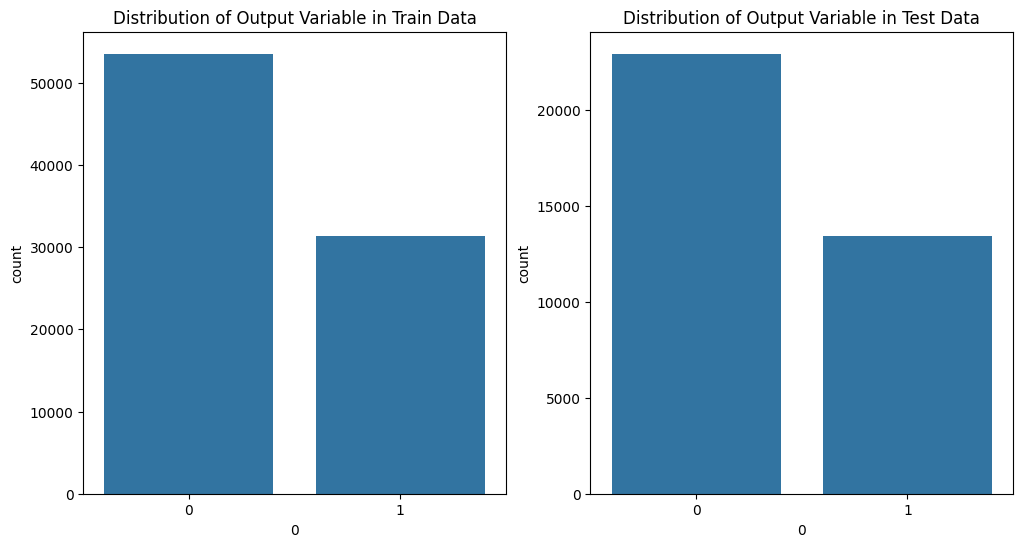

In [111]:
# Plotting the distribution of the output variable in train data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train.iloc[:, 0])
plt.title('Distribution of Output Variable in Train Data')

# Plotting the distribution of the output variable in test data
plt.subplot(1, 2, 2)
sns.countplot(x=y_test.iloc[:, 0])
plt.title('Distribution of Output Variable in Test Data')

plt.show()

## Logistic Regression ----> Baseline Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def logistic_regression_function(X_train, X_test, y_train, y_test):
    logreg_model = LogisticRegression(random_state=42)
    logreg_model.fit(X_train, y_train)
    train_predictions = logreg_model.predict(X_train)
    test_predictions = logreg_model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    print(f'Train Accuracy: {train_accuracy:.5f}')
    print(f'Test Accuracy: {test_accuracy:.5f}')
    # Display confusion matrix
    cm = confusion_matrix(y_test, test_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg_model.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

Train Accuracy: 0.76870
Test Accuracy: 0.76137


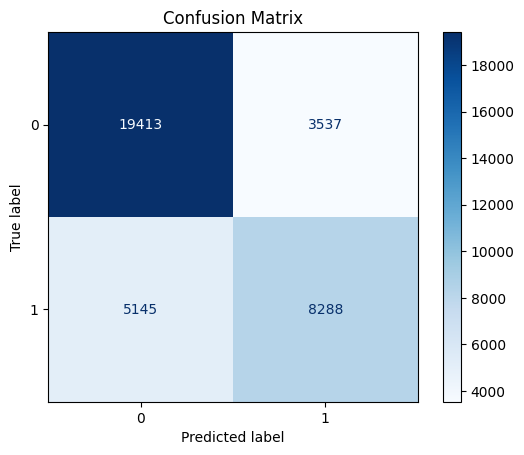

In [117]:
logistic_regression_function(X_train, X_test, y_train, y_test)

## XGBoost for prediction </br>

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm

def xgboost_random_search_gpu(X_train, X_test, y_train, y_test):
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'learning_rate': [0.01, 0.1, 0.2, 0.3],
        'max_depth': [3, 5, 7, 9],
        'subsample': [0.5, 0.7, 0.9, 1.0],
        'colsample_bytree': [0.5, 0.7, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'tree_method': ['gpu_hist'],
        'gpu_id': [0]
    }

    xgb_clf = XGBClassifier(random_state=42, tree_method='gpu_hist', gpu_id=0)
    random_search = RandomizedSearchCV(
        xgb_clf,
        param_distributions=param_dist,
        scoring='accuracy',  
        n_iter=10,  
        cv=5,
        n_jobs=1,
        verbose=10
    )
    random_search.fit(X_train, y_train)
    print("Best Parameters:", random_search.best_params_)
    best_model = random_search.best_estimator_
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    print(f'Train Accuracy: {train_accuracy:.5f}')
    print(f'Test Accuracy: {test_accuracy:.5f}')
    cm = confusion_matrix(y_test, test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title('Confusion Matrix')
    plt.show()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3; 1/10] START colsample_bytree=0.5, gamma=0.1, gpu_id=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9, tree_method=gpu_hist
[CV 1/3; 1/10] END colsample_bytree=0.5, gamma=0.1, gpu_id=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9, tree_method=gpu_hist;, score=0.775 total time=   3.5s
[CV 2/3; 1/10] START colsample_bytree=0.5, gamma=0.1, gpu_id=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9, tree_method=gpu_hist
[CV 2/3; 1/10] END colsample_bytree=0.5, gamma=0.1, gpu_id=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9, tree_method=gpu_hist;, score=0.775 total time=   2.8s
[CV 3/3; 1/10] START colsample_bytree=0.5, gamma=0.1, gpu_id=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9, tree_method=gpu_hist
[CV 3/3; 1/10] END colsample_bytree=0.5, gamma=0.1, gpu_id=0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample

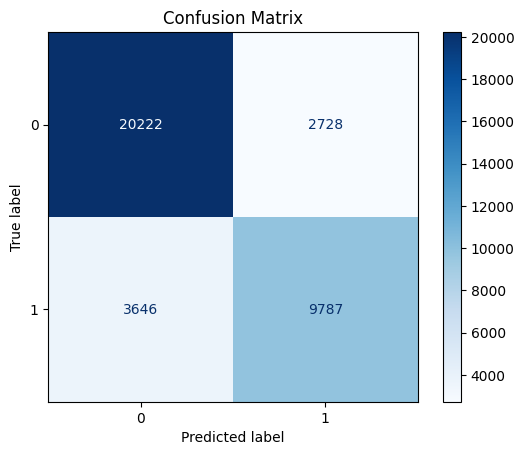

In [121]:
xgboost_random_search_gpu(X_train, X_test, y_train, y_test)

## Now Let's Try with Bert!

In [ ]:
data = pd.read_csv('train.csv')

data = data.dropna(subset=['question1', 'question2'])
data = data[data['question1'].str.strip() != '']
data = data[data['question2'].str.strip() != '']
class_proportions = data['is_duplicate'].value_counts(normalize=True)
sample_size = int(0.3 * len(data))
stratified_sample = data.groupby('is_duplicate', group_keys=False).apply(
    lambda x: x.sample(n=int(class_proportions[x.name] * sample_size), random_state=42)
)
stratified_sample = stratified_sample.reset_index(drop=True)

# Splitting dataset into train, validation, and test sets
train_val, test = train_test_split(stratified_sample, test_size=0.2, stratify=stratified_sample['is_duplicate'], random_state=42)
train, val = train_test_split(train_val, test_size=0.2, stratify=train_val['is_duplicate'], random_state=42)

In [ ]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load pre-trained BERT model and tokenizer
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("BERT model and tokenizer loaded")

# Define Siamese BERT model
class SiameseBERT(nn.Module):
    def __init__(self):
        super(SiameseBERT, self).__init__()
        self.bert = bert_model
        self.fc = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )

    def forward(self, input1, input2):
        embed1 = self.fc(self.bert(**input1)[1])
        embed2 = self.fc(self.bert(**input2)[1])
        cos_sim = F.cosine_similarity(embed1, embed2)
        return cos_sim

# Create model instance
siamese_bert = SiameseBERT().to(device)
print("Siamese BERT model created")

# Tokenization and encoding function
def tokenize_and_encode(texts, text_pairs=None, max_length=128):
    if text_pairs:
        return tokenizer(texts, text_pairs, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
    else:
        return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')

# Data augmentation
aug = SynonymAug(aug_src='wordnet')

def augment_question(question):
    augmented = aug.augment(question)
    return augmented if augmented else question

# Prepare datasets
def prepare_dataset(df):
    encoded1 = tokenize_and_encode(df['question1'].tolist())
    encoded2 = tokenize_and_encode(df['question2'].tolist())
    labels = torch.tensor(df['is_duplicate'].values, dtype=torch.float32)
    
    # Augment data
    augmented_q1 = [str(augment_question(q)) for q in df['question1'] if augment_question(q)]
    augmented_q2 = [str(augment_question(q)) for q in df['question2'] if augment_question(q)]
    encoded_aug1 = tokenize_and_encode(augmented_q1)
    encoded_aug2 = tokenize_and_encode(augmented_q2)
    
    # Combine original and augmented data
    combined_encoded1 = {k: torch.cat([encoded1[k], encoded_aug1[k]]) for k in encoded1.keys()}
    combined_encoded2 = {k: torch.cat([encoded2[k], encoded_aug2[k]]) for k in encoded2.keys()}
    combined_labels = torch.cat([labels, labels[:len(augmented_q1)]])
    
    return torch.utils.data.TensorDataset(
        combined_encoded1['input_ids'], combined_encoded1['attention_mask'],
        combined_encoded2['input_ids'], combined_encoded2['attention_mask'],
        combined_labels
    )

train_dataset = prepare_dataset(train)
val_dataset = prepare_dataset(val)
test_dataset = prepare_dataset(test)
print("Datasets prepared")

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)
print("Data loaders created")

# Define optimizer, loss function, and scheduler
optimizer = torch.optim.Adam(siamese_bert.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output, label):
        loss_contrastive = torch.mean((1-label) * torch.pow(output, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - output, min=0.0), 2))
        return loss_contrastive

loss_fn = ContrastiveLoss()
print("Optimizer, loss function, and scheduler defined")

# Training loop
def train_model(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch in loader:
        input1 = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device)}
        input2 = {'input_ids': batch[2].to(device), 'attention_mask': batch[3].to(device)}
        labels = batch[4].to(device)
        
        optimizer.zero_grad()
        outputs = model(input1, input2)
        loss = loss_fn(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for batch in loader:
            input1 = {'input_ids': batch[0].to(device), 'attention_mask': batch[1].to(device)}
            input2 = {'input_ids': batch[2].to(device), 'attention_mask': batch[3].to(device)}
            labels = batch[4].to(device)
            
            outputs = model(input1, input2)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            all_outputs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate Spearman's rank correlation
    from scipy.stats import spearmanr
    correlation, _ = spearmanr(all_outputs, all_labels)
    
    return total_loss / len(loader), correlation

# Train the model
num_epochs = 10
best_val_corr = 0
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_loss = train_model(siamese_bert, train_loader, optimizer, loss_fn)
    val_loss, val_corr = evaluate(siamese_bert, val_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Correlation: {val_corr:.4f}")
    
    scheduler.step(val_corr)
    
    if val_corr > best_val_corr:
        best_val_corr = val_corr
        torch.save(siamese_bert.state_dict(), 'best_siamese_bert_model.pth')
        print("New best model saved")

# Evaluate on test set
siamese_bert.load_state_dict(torch.load('best_siamese_bert_model.pth'))
test_loss, test_corr = evaluate(siamese_bert, test_loader)
print(f"Test Loss: {test_loss:.4f}, Test Correlation: {test_corr:.4f}")



Using device: cuda
BERT model and tokenizer loaded
Siamese BERT model created
Datasets prepared
Data loaders created
Optimizer, loss function, and scheduler defined
Starting epoch 1
Epoch 1, Train Loss: 0.0682, Val Loss: 0.0730, Val Correlation: 0.4695
New best model saved
Starting epoch 2
Epoch 2, Train Loss: 0.0516, Val Loss: 0.0646, Val Correlation: 0.5258
New best model saved
Starting epoch 3
Epoch 3, Train Loss: 0.0464, Val Loss: 0.0597, Val Correlation: 0.5492
New best model saved
Starting epoch 4
Epoch 4, Train Loss: 0.0417, Val Loss: 0.0562, Val Correlation: 0.5779
New best model saved
Starting epoch 5
Epoch 5, Train Loss: 0.0371, Val Loss: 0.0561, Val Correlation: 0.5964
New best model saved
Starting epoch 6
Epoch 6, Train Loss: 0.0329, Val Loss: 0.0531, Val Correlation: 0.6017
New best model saved
Starting epoch 7
Epoch 7, Train Loss: 0.0286, Val Loss: 0.0546, Val Correlation: 0.6102
New best model saved
Starting epoch 8
Epoch 8, Train Loss: 0.0246, Val Loss: 0.0520, Val Corr

/tmp/ipykernel_6134/2125883191.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese_bert.load_state_dict(torch.load('best_siamese_bert_model.pth'))


Test Loss: 0.0548, Test Correlation: 0.6199
Question 1: How to lose weight?
Question 2: How to lose weight?
Similarity: 0.9999999701976776


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
class SiameseBERT(nn.Module):
    def __init__(self):
        super(SiameseBERT, self).__init__()
        self.bert = bert_model
        self.fc = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Linear(256, 128)
        )
    def forward(self, input1, input2):
        embed1 = self.fc(self.bert(**input1)[1])
        embed2 = self.fc(self.bert(**input2)[1])
        cos_sim = F.cosine_similarity(embed1, embed2)
        return cos_sim
siamese_bert = SiameseBERT().to(device)
siamese_bert.load_state_dict(torch.load('best_siamese_bert_model.pth'))
siamese_bert.eval()
def tokenize_and_encode(texts, max_length=128):
    return tokenizer(texts, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
def predict_similarity(question1, question2):
    encoded1 = tokenize_and_encode([question1])
    encoded2 = tokenize_and_encode([question2])
    input1 = {k: v.to(device) for k, v in encoded1.items()}
    input2 = {k: v.to(device) for k, v in encoded2.items()}
    with torch.no_grad():
        similarity = siamese_bert(input1, input2)
    return (similarity.item() + 1) / 2 

/tmp/ipykernel_1923/530954623.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  siamese_bert.load_state_dict(torch.load('best_siamese_bert_model.pth'))


In [11]:
q1 = "How can I lose weight quickly? "
q2 = "What's the easiest way to lose weight"
similarity = predict_similarity(q1, q2)
print(f"Question 1: {q1}")
print(f"Question 2: {q2}")
print(f"Similarity: {similarity}")

Question 1: How can I lose weight quickly? 
Question 2: What's the easiest way to lose weight
Similarity: 0.526941355317831
